In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def generateLinearTrajectory(t, x0 = 100, vy = 100, y=0, h = 20, sigma2 = 0):
    return np.sqrt(x0**2+((vy*t)+y)**2+h**2) + sigma2*np.random.randn(len(t))

def generateLinearTrajectory(t, x0 = 100, vx=1, vy = 100, y=0, h = 20, vh=2, sigma2 = 0):
    return np.sqrt(((vx*t)+x0)**2+((vy*t)+y)**2+((vh*t)+h)**2) + sigma2*np.random.randn(len(t))

def SSE(y_true, y_hat):
    return sum(y_true - y_hat)**2

class history:
    def __init__(self):
        self.x0 = []
        self.h = []
        self.vy = []
        self.loss = []
        
    def plotHistory(self):
        plt.figure()
        plt.plot(self.x0)
        plt.plot(self.h)
        plt.plot(self.vy)
        plt.legend(['xo','h','vy'])
        plt.xlabel("iter")
        plt.ylabel("parameter value")
        plt.figure()
        plt.plot(np.arange(1,len(self.loss[100:])+1), self.loss[100:])
        plt.xlabel("iter")
        plt.ylabel("loss")
        plt.show()
        

class channel:
    def __init__(self, recordedTrajectory, t, x=0, y=0, z=0):
        # position
        self.x = x
        self.y = y
        self.z = z
        self.t = t
        self.recordedTrajectory = recordedTrajectory

class LinearTtrajectory:
    def __init__(self, lr = 0.0001):
        # initiallizae
        self.x0 = 10
        self.vy = 10
        self.h = 10
        self.lr = lr

    def makePlots(self, channels, fithistory, x0, vy, h):
        print(f"x0: {self.x0}  h: {self.h} vy: {self.vy}")
        fithistory.plotHistory()
        plt.plot(channels[0].t, channels[0].recordedTrajectory)
        plt.plot(channels[0].t, self.f(channels[0].t, self.x0, self.vy, channels[0].y, self.h))
        plt.plot(channels[0].t, self.f(channels[0].t, x0, vy, channels[0].y, h))
        plt.legend(["measured", "fitted", "real"])
        plt.xlabel("time [s]")
        plt.ylabel("range [m]")
        plt.show()

    def f(self, t, x0, vy, y, h):
        return np.sqrt(x0**2+((vy*t)+y)**2+h**2)

    def df_by_dx0(self, x0, y_true, y_hat, vy, y, t, h):
        return sum((2*x0*(y_true-y_hat))/self.f(t,x0,vy,y,h))

    def df_by_dh(self, x0, y_true, y_hat, vy, y, t, h):
        return sum((2*h*(y_true-y_hat))/self.f(t,x0,vy,y,h))

    def df_by_dvy(self, x0, y_true, y_hat, vy, y, t, h):
        return sum((2*vy*t**2*(y_true-y_hat))/self.f(t,x0,vy,y,h))
    
    def fit(self, channels, iterations):
        fithistory = history()
        t = channels[0].t # can times here be different?

        for _ in range(iterations):
            for channel in channels:
                y_hat = self.f(t, self.x0+channel.x, self.vy, channel.y, self.h+channel.z)
                self.x0 += self.lr*self.df_by_dx0(self.x0, channel.recordedTrajectory, y_hat, self.vy, channel.y, t, self.h)
                self.h += self.lr*self.df_by_dh(self.x0, channel.recordedTrajectory, y_hat, self.vy, channel.y, t, self.h)
                self.vy += self.lr*self.df_by_dvy(self.x0, channel.recordedTrajectory, y_hat, self.vy, channel.y, t, self.h)
            fithistory.x0.append(self.x0)
            fithistory.h.append(self.h)
            fithistory.vy.append(self.vy)

            fithistory.loss.append(SSE(y_hat, channel.recordedTrajectory)) # this is not true, but is close enough
        return fithistory


class ConstantSpeed:
    def __init__(self, lr = 0.0001):
        # initiallizae
        self.x0 = 10
        self.vx = 1
        self.y = 10
        self.vy = 10
        self.h = 10
        self.vh = 1
        self.lr = lr

    def makePlots(self, channels, fithistory, x0, vy, h):
        print(f"x0: {self.x0}  h: {self.h} vy: {self.vy}")
        fithistory.plotHistory()
        plt.plot(channels[0].t, channels[0].recordedTrajectory)
        plt.plot(channels[0].t, self.f(channels[0].t, self.x0, self.vy, channels[0].y, self.h))
        plt.plot(channels[0].t, self.f(channels[0].t, x0, vy, channels[0].y, h))
        plt.legend(["measured", "fitted", "real"])
        plt.xlabel("time [s]")
        plt.ylabel("range [m]")
        plt.show()

    def f(self, t, vx, x0, vy, y, vh, h):
        return np.sqrt((vx*t+x0)**2 + (vy*t+y)**2 + (vh*t+h)**2)

    def dSSE_by_dvx(self, y_true, y_hat, t, vx, x0, vy, y, vh, h):
        return sum((2*(vx*t+x0)*t * (y_true-y_hat)) / self.f(self, t, vx, x0, vy, y, vh, h))

    def dSSE_by_dx0(self, y_true, y_hat, t, vx, x0, vy, y, vh, h):
        return sum((2*(vx*t+x0) * (y_true-y_hat)) / self.f(self, t, vx, x0, vy, y, vh, h))

    def dSSE_by_dvy(self, y_true, y_hat, t, vx, x0, vy, y, vh, h):
        return sum((2*(vy*t+y)*t * (y_true-y_hat)) / self.f(self, t, vx, x0, vy, y, vh, h))

    def dSSE_by_dy(self, y_true, y_hat, t, vx, x0, vy, y, vh, h):
        return sum((2*(vy*t+y) * (y_true-y_hat)) / self.f(self, t, vx, x0, vy, y, vh, h))

    def dSSE_by_dvh(self, y_true, y_hat, t, vx, x0, vy, y, vh, h):
        return sum((2*(vh*t+h)*t * (y_true-y_hat)) / self.f(self, t, vx, x0, vy, y, vh, h))

    def dSSE_by_dh(self, y_true, y_hat, t, vx, x0, vy, y, vh, h):
        return sum((2*(vh*t+h) * (y_true-y_hat)) / self.f(self, t, vx, x0, vy, y, vh, h))
    
    def fit(self, channels, iterations):
        fithistory = history()
        t = channels[0].t # can times here be different?

        for _ in range(iterations):
            for channel in channels:
                y_hat = self.f(t, self.x0+channel.x, self.vy, channel.y, self.h+channel.z)
                self.x0 += self.lr*self.df_by_dx0(self.x0, channel.recordedTrajectory, y_hat, self.vy, channel.y, t, self.h)
                self.h += self.lr*self.df_by_dh(self.x0, channel.recordedTrajectory, y_hat, self.vy, channel.y, t, self.h)
                self.vy += self.lr*self.df_by_dvy(self.x0, channel.recordedTrajectory, y_hat, self.vy, channel.y, t, self.h)
            fithistory.x0.append(self.x0)
            fithistory.h.append(self.h)
            fithistory.vy.append(self.vy)

            fithistory.loss.append(SSE(y_hat, channel.recordedTrajectory)) # this is not true, but is close enough
        return fithistory

# single channel

x0: 84.03784185101476  h: 57.77898843916104 vy: 99.92408521173672


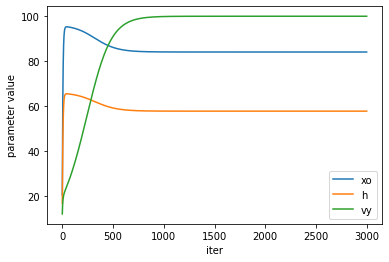

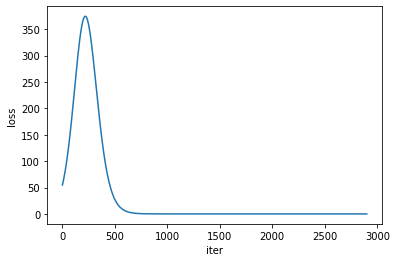

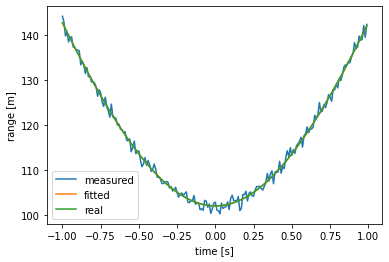

In [3]:
# time
t = np.arange(-1,1,1e-2)

# movement parmeters (what we'll be fittting)
x0 = 100
vy = 100
h = 20

# channel position
x = 0
y = 0
z = 0
ch1 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=1), t, x, y, z)

# model
model = LinearTtrajectory(lr=0.0004)
fithistory = model.fit([ch1], 3000)
model.makePlots([ch1], fithistory, x0, vy, h)

# 2 channels

x0: 203.5666561225239  h: 1.8726773203949966e-49 vy: 101.59581519605966


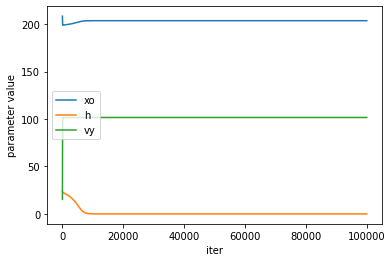

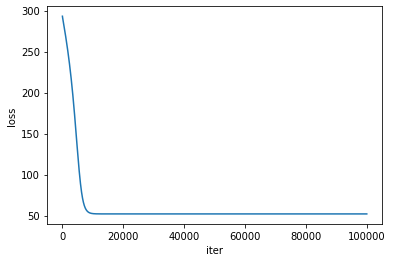

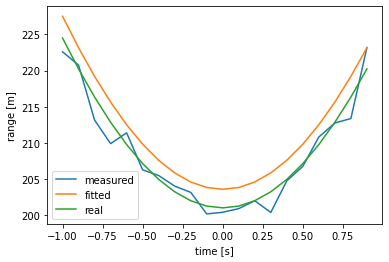

In [5]:
# time
t = np.arange(-1,1,1e-1)

# movement parmeters (what we'll be fittting)
x0 = 200
vy = 100
h = 20
sigma2 = 2

# channel position
x = 0
y = 0
z = 0
ch1 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma2), t, x, y, z)

# channel position
x = 0
y = 0
z = 10
ch2 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma2), t, x, y, z)

# channel position
x = 10
y = 0
z = 30
ch3 = channel(generateLinearTrajectory(t, x0+x, vy, y, h+z, sigma2=sigma2), t, x, y, z)

# model
model = LinearTtrajectory(lr=0.04)
fithistory = model.fit([ch1, ch2, ch3], int(1e5))
model.makePlots([ch1],fithistory, x0, vy, h)